<a href="https://colab.research.google.com/github/vladsavelyev/deeplearning/blob/master/makemore_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from pathlib import Path
import requests
data_path = Path('names.txt')
if not data_path.exists():
    r = requests.get('https://raw.githubusercontent.com/vladsavelyev/deeplearning/master/karpathy/names.txt')
    with data_path.open('wb') as f:
        f.write(r.content)

with data_path.open() as f:
    words = f.read().split()

print(words[:10])
print(f'{len(words)=}, {max(len(w) for w in words)=}, {min(len(w) for w in words)=}')

vocab = ['.'] + sorted(list(set(''.join(words))))
itos = {k: v for k, v in enumerate(vocab)}
stoi = {v: k for k, v in itos.items()}
print(len(vocab), vocab)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
len(words)=32033, max(len(w) for w in words)=15, min(len(w) for w in words)=2
27 ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xtest, Ytest = build_dataset(words[n2:])  # 10%
len(Xtr), len(Xdev), len(Xtest)

(182625, 22655, 22866)

Model parameters number 11897
i=0, lr=0.1, loss_dev=26.972827911376953
i=250, lr=0.1, loss_dev=11.267903327941895
i=500, lr=0.1, loss_dev=10.283339500427246
i=750, lr=0.1, loss_dev=9.939946174621582
i=1000, lr=0.1, loss_dev=9.856738090515137
i=1250, lr=0.1, loss_dev=9.343185424804688
i=1500, lr=0.1, loss_dev=9.262591361999512
i=1750, lr=0.1, loss_dev=9.092727661132812
i=2000, lr=0.1, loss_dev=8.89587116241455
i=2250, lr=0.1, loss_dev=9.080263137817383
i=2500, lr=0.1, loss_dev=9.174175262451172
i=2750, lr=0.01, loss_dev=8.65758991241455
i=3000, lr=0.01, loss_dev=8.742416381835938
i=3250, lr=0.01, loss_dev=8.729799270629883
i=3500, lr=0.01, loss_dev=8.646295547485352
i=3750, lr=0.01, loss_dev=8.724937438964844
i=4000, lr=0.01, loss_dev=8.600601196289062
i=4250, lr=0.01, loss_dev=8.549229621887207
i=4500, lr=0.01, loss_dev=8.5711669921875
i=4750, lr=0.01, loss_dev=8.543848037719727
Final dev loss: 8.571316719055176
Final test loss: 8.486486434936523


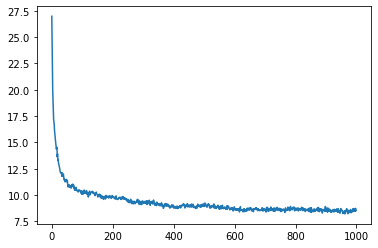

In [ ]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(42)  # for reproducibility
C  = torch.randn(len(vocab), n_embd,               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, len(vocab)),           generator=g)
b2 = torch.randn(len(vocab),                       generator=g)

parameters = [C, W1, b1, W2, b2]
print('Model parameters number', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# Training
max_steps = 5_000
batch_size = 32
learning_rate = 0.1

lossi = []

@torch.no_grad()
def calc_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x].view(-1, block_size * n_embd)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y)
    
for i in range(max_steps):
    lr = learning_rate
    if i > max_steps / 2:
        lr = learning_rate / 10

    # minibatch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)

    # forward pass
    emb = C[Xtr[ix]].view(-1, block_size * n_embd)  # embed chars into vectors
    h_pre_act = emb @ W1 + b1
    h_pre_act = (h_pre_act - h_pre_act.mean(0, keepdim=True)) / h_pre_act.std(0, keepdim=True)
    h = torch.tanh(h_pre_act)  # hidden layer actications
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Ytr[ix])  # loss function
    # equivalent to (assuming probs = F.softmax(logits, dim=1)):
    # loss = = F.nll_loss(probs.log(), Ytr[ix])
    # loss = -probs[torch.arange(start=0, end=len(ix)), Ytr[ix]].log().mean()

    # track stats for 1000 steps
    if i % (max_steps / 1000) == 0:
        lossi.append(calc_loss('dev'))
        # print 100 steps
        if i % (max_steps / 20) == 0:
            print(f'{i=}, {lr=}, loss_dev={lossi[-1]}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # paramter update
    for p in parameters:
        p.data -= learning_rate * p.grad

print(f'Final dev loss: {calc_loss("dev")}')
print(f'Final test loss: {calc_loss("test")}')

plt.plot([i for i in range(len(lossi))], lossi)

### MLP revisited

Model parameters number 12297
i=0, lr=0.1, loss_dev=3.850111484527588
i=50, lr=0.1, loss_dev=2.8674252033233643
i=100, lr=0.1, loss_dev=2.7263355255126953
i=150, lr=0.1, loss_dev=2.6712710857391357
i=200, lr=0.1, loss_dev=2.6524930000305176
i=250, lr=0.1, loss_dev=2.610372304916382
i=300, lr=0.1, loss_dev=2.5445029735565186
i=350, lr=0.1, loss_dev=2.5302135944366455
i=400, lr=0.1, loss_dev=2.528202533721924
i=450, lr=0.1, loss_dev=2.5197653770446777
i=500, lr=0.1, loss_dev=2.492495536804199
i=550, lr=0.01, loss_dev=2.4690024852752686
i=600, lr=0.01, loss_dev=2.4776456356048584
i=650, lr=0.01, loss_dev=2.454249620437622
i=700, lr=0.01, loss_dev=2.463658571243286
i=750, lr=0.01, loss_dev=2.4479691982269287
i=800, lr=0.01, loss_dev=2.4451780319213867
i=850, lr=0.01, loss_dev=2.4230170249938965
i=900, lr=0.01, loss_dev=2.4406495094299316
i=950, lr=0.01, loss_dev=2.4332046508789062
Final dev loss: 2.424267292022705
Final test loss: 2.424990177154541


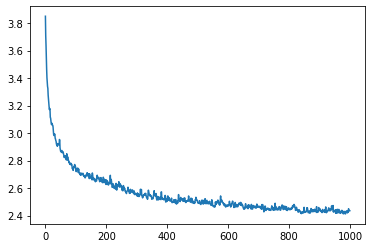

In [ ]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(42)  # for reproducibility
C  = torch.randn(len(vocab), n_embd,               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, len(vocab)),           generator=g) * 0.1
b2 = torch.randn(len(vocab),                       generator=g) * 0
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))    
bn_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]
print('Model parameters number', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# Training
max_steps = 1000
batch_size = 32
learning_rate = 0.1

lossi = []

# # The network expects batches as inputs for the normalisation
# # layer, so it wouldn't work with single inputs. TO fix this,
# # we will measure mean/std over the entire training set and use 
# # that for the normalisation in loss estimation.
# with torch.no_grad():
#     emb = C[Xtr].view(-1, block_size * n_embd)
#     hpreact = emb @ W1 + b1
#     # pass the training set through
#     # measure the mean/std over the entire training set
#     bn_mean = hpreact.mean(0, keepdim=True)
#     bn_std = hpreact.std(0, keepdim=True)

@torch.no_grad()
def calc_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x].view(-1, block_size * n_embd)
    hpreact = emb @ W1 + b1
    hpreact = (
        bn_gain * (hpreact - bn_mean_running) / bn_std_running + 
        bn_bias
    )
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y)

for i in range(max_steps):
    lr = learning_rate
    if i > max_steps / 2:
        lr = learning_rate / 10

    # minibatch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)

    # forward pass
    emb = C[Xtr[ix]].view(-1, block_size * n_embd)  # embed chars into vectors
    hpreact = emb @ W1 + b1

    # batch-normalising activations
    bn_mean_i = hpreact.mean(0, keepdim=True)
    bn_std_i = hpreact.std(0, keepdim=True)
    hpreact = hpreact - bn_mean_i / bn_std_i
    # but to avoid overnirmalisation, scalling/offsetting by a learned gain/bias
    hpreact = bn_gain * hpreact + bn_bias

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i

    h = torch.tanh(hpreact)  # hidden layer actications
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Ytr[ix])  # loss function
    # equivalent to (assuming probs = F.softmax(logits, dim=1)):
    # loss = = F.nll_loss(probs.log(), Ytr[ix])
    # loss = -probs[torch.arange(start=0, end=len(ix)), Ytr[ix]].log().mean()

    # track stats for 1000 steps
    if i % (max_steps / 1000) == 0:
        lossi.append(calc_loss('dev'))
        # print 100 steps
        if i % (max_steps / 20) == 0:
            print(f'{i=}, {lr=}, loss_dev={lossi[-1]}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # paramter update
    for p in parameters:
        p.data -= learning_rate * p.grad

print(f'Final dev loss: {calc_loss("dev")}')
print(f'Final test loss: {calc_loss("test")}')

plt.plot([i for i in range(len(lossi))], lossi)

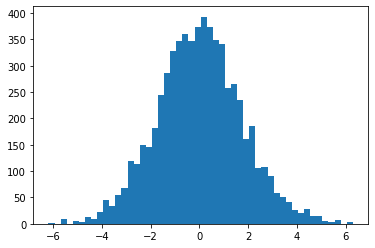

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

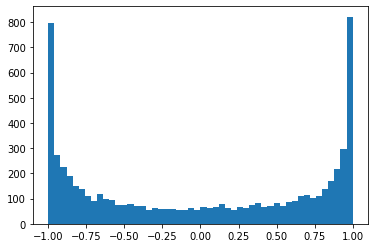

In [ ]:
plt.hist(hpreact.tanh().view(-1).tolist(), 50);

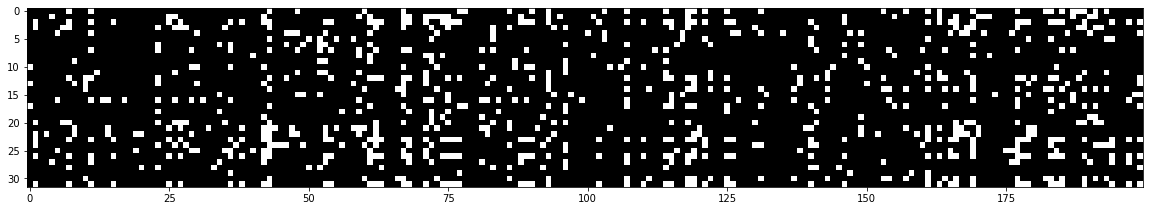

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
n_words = 15
g = torch.Generator().manual_seed(42)
max_word_len = 20
for _ in range(n_words):
    context = [0] * block_size
    losses = []
    for _ in range(max_word_len):
        x = torch.tensor(context[-block_size:]).view(1, block_size)
        emb = C[x].view(-1, n_embd * block_size)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        next_char = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context.append(next_char)
        losses.append(-probs[0, next_char].log().mean().item())
        if next_char == 0:
            break
    gen_chars = context[3:]
    gen_word = ''.join(map(itos.get, gen_chars))
    print(f'{gen_word:<{max_word_len}} {sum(losses) / len(losses):.2f}')

abdanevoan.          2.45
journ.               1.77
mik.                 1.94
mar.                 1.68
aya.                 1.79
alee.                1.58
liu.                 3.30
hay.                 1.98
jayse.               1.51
mira.                1.24
khyah.               1.80
davereelyn.          1.91
julai.               2.31
jeharne.             1.94
sydn.                2.27


In [ ]:
n_words = 15
g = torch.Generator().manual_seed(42)
max_word_len = 20
for _ in range(n_words):
    context = [0] * block_size
    losses = []
    for _ in range(max_word_len):
        x = torch.tensor(context[-block_size:]).view(1, block_size)
        emb = C[x].view(-1, n_embd * block_size)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        next_char = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context.append(next_char)
        losses.append(-probs[0, next_char].log().mean().item())
        if next_char == 0:
            break
    gen_chars = context[3:]
    gen_word = ''.join(map(itos.get, gen_chars))
    print(f'{gen_word:<{max_word_len}} {sum(losses) / len(losses):.2f}')

aba.                 2.23
mayta.               2.08
bhpsllangr.          2.96
nak.                 1.76
azah.                1.70
dakbiro.             2.67
fiz.                 2.71
kazul.               2.17
nnomarlzakle.        2.66
narishon.            1.50
mvedr.               2.50
mddepnn.             3.23
tycr.                2.87
azo.                 2.45
lulen.               2.07


In [ ]:
logits = torch.randn(20)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([ 0.4406,  0.4513, -2.2993,  0.9727, -0.6603, -1.1651,  1.1700,  0.5012,
         -1.4625,  0.2814,  0.4767,  2.2758, -0.1745,  0.1286, -0.0716,  0.0424,
          0.2002, -0.6215,  0.2808,  1.0826]),
 tensor([0.0451, 0.0456, 0.0029, 0.0768, 0.0150, 0.0091, 0.0935, 0.0479, 0.0067,
         0.0385, 0.0467, 0.2825, 0.0244, 0.0330, 0.0270, 0.0303, 0.0355, 0.0156,
         0.0384, 0.0857]),
 tensor(5.8392))

In [ ]:
logits = torch.tensor([0.0] * 20)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
         0.0500, 0.0500]),
 tensor(2.9957))

In [ ]:
g = torch.Generator().manual_seed(42)  # for reproducibility

class Embedding:
    def __init__(self, vocab_len, block_size, n_embd):
        self.out = None
        self.n_embd = n_embd
        self.block_size = block_size
        self.C = torch.randn((vocab_len, n_embd), generator=g)
    
    def __call__(self, x):
        self.out = self.C[x].view(-1, self.block_size * self.n_embd)
        return self.out
    
    def parameters(self):
        return [self.C]

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.out = None
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias is not None else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.out = None
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params (trained with backprop)
        self.weight = torch.ones(dim)
        self.bias = torch.zeros(dim)
        # buffers (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True, unbiased=True)
        else:
            mean = self.running_mean
            var = self.running_var
        # normalise to unit variance
        x = (x - mean) / torch.sqrt(var + self.eps)
        self.out = self.weight * x + self.bias
        if self.training:
            # update running buffers
            with torch.no_grad():
                self.running_mean = (
                    (1 - self.momentum) * self.running_mean + 
                    self.momentum * mean
                ) 
                self.running_var = (
                    (1 - self.momentum) * self.running_var +
                    self.momentum * var
                )
        return self.out

    def parameters(self):
        return [self.weight, self.bias]

class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

layers = [
    Embedding(vocab_len=len(vocab), block_size=block_size, n_embd=n_embd), 
    Linear(block_size * n_embd, n_hidden), 
    BatchNorm1d(dim=n_hidden),
    Tanh(), 
    Linear(n_hidden, n_hidden), 
    BatchNorm1d(dim=n_hidden),
    Tanh(), 
    Linear(n_hidden, n_hidden), 
    BatchNorm1d(dim=n_hidden),
    Tanh(), 
    Linear(n_hidden, n_hidden), 
    BatchNorm1d(dim=n_hidden),
    Tanh(), 
    Linear(n_hidden, n_hidden), 
    BatchNorm1d(dim=n_hidden),
    Tanh(), 
    Linear(n_hidden, n_hidden), 
    BatchNorm1d(dim=n_hidden),
    Tanh(),
    Linear(n_hidden, len(vocab)),
    BatchNorm1d(dim=len(vocab)),
]

with torch.no_grad():
    # last layer: make it less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 5/3  # for tanh

parameters = [p for l in layers for p in l.parameters()]
print('Model parameters number', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# Training
max_steps = 1000
batch_size = 32
learning_rate = 0.1

@torch.no_grad()
def calc_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]

    for l in layers:
        x = l(x)
    return F.cross_entropy(x, y)

lossi = []  # for stats
ud_by_param_by_iter = {}  # for stats
for i in range(max_steps):
    lr = learning_rate
    if i > max_steps / 2:
        lr = learning_rate / 10

    # minibatch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    x = Xtr[ix]
    y = Ytr[ix]

    # forward pass
    for l in layers:
        x = l(x)

    loss = F.cross_entropy(x, y)

    # DEBUG: retaining grads for outputs, otherwise calc_loss below will 
    # drop them because of the no_grad decorator
    for l in layers:
        l.out.retain_grad()

    # # track stats for 1000 steps
    # if i % (max_steps / 1000) == 0:
    #     lossi.append(calc_loss('dev'))
    #     # print 100 steps
    #     if i % (max_steps / 20) == 0:
    #         print(f'{i=}, {lr=}, loss_dev={lossi[-1]}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # paramter update
    for p in parameters:
        p.data -= learning_rate * p.grad

    with torch.no_grad():
        ud_by_param_by_iter[i] = {
            j:
            (learning_rate * p.grad.std() / p.data.std()).log10().item() 
            for j, p in enumerate(parameters)
        }

# print(f'Final dev loss: {calc_loss("dev")}')
# print(f'Final test loss: {calc_loss("test")}')
# plt.plot([i for i in range(len(lossi))], lossi)

Model parameters number 215351


Layer 3 (Tanh): mean: -0.00, std: 0.64, saturated: 2.33%
Layer 6 (Tanh): mean: 0.00, std: 0.64, saturated: 2.50%
Layer 9 (Tanh): mean: 0.00, std: 0.64, saturated: 2.34%
Layer 12 (Tanh): mean: -0.00, std: 0.64, saturated: 2.39%
Layer 15 (Tanh): mean: 0.00, std: 0.64, saturated: 2.19%
Layer 18 (Tanh): mean: 0.00, std: 0.64, saturated: 1.94%


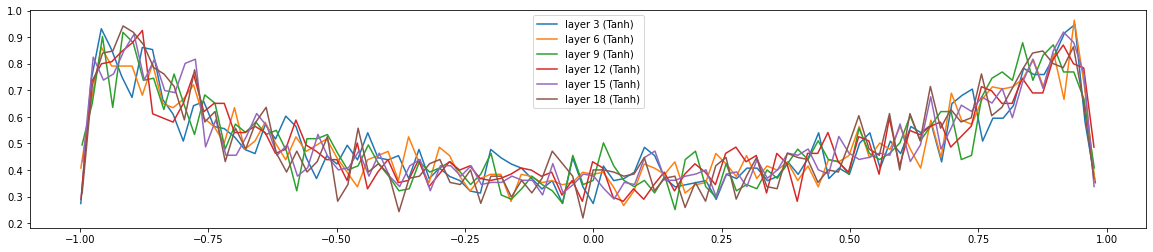

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, l in enumerate(layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out
        print(
            f'Layer {i} ({l.__class__.__name__}): '
            f'mean: {t.mean().item():.2f}, std: {t.std().item():.2f}, '
            f'saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__})')
plt.legend(legends)

Layer 3   (Tanh): mean: -0.0000, std: 0.0019, saturated: 0.0000%
Layer 6   (Tanh): mean: -0.0000, std: 0.0016, saturated: 0.0000%
Layer 9   (Tanh): mean: +0.0000, std: 0.0015, saturated: 0.0000%
Layer 12  (Tanh): mean: +0.0000, std: 0.0015, saturated: 0.0000%
Layer 15  (Tanh): mean: +0.0000, std: 0.0014, saturated: 0.0000%
Layer 18  (Tanh): mean: +0.0000, std: 0.0014, saturated: 0.0000%


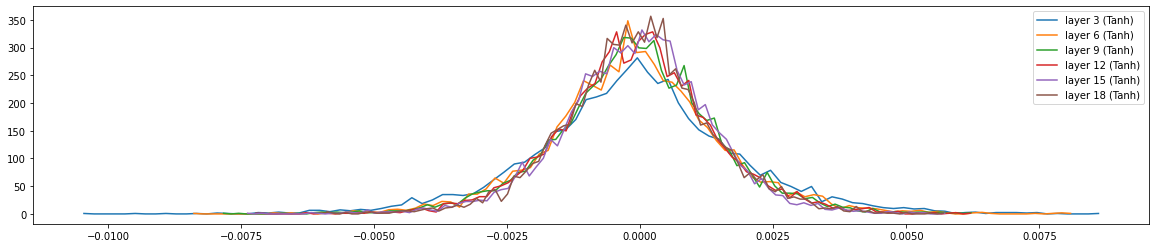

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, l in enumerate(layers[:-1]):
    if isinstance(l, Tanh):
        t = l.out.grad
        print(
            f'Layer {i:<3} ({l.__class__.__name__}): '
            f'mean: {t.mean().item():+.4f}, std: {t.std().item():.4f}, '
            f'saturated: {(t.abs() > 0.97).float().mean()*100:.4f}%'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__})')
plt.legend(legends);

weight (27, 10)  : mean: +0.0000, std: 0.0082, grad:data: -0.0376
weight (30, 200) : mean: +0.0001, std: 0.0046, grad:data: +0.0022
weight (200, 200): mean: -0.0000, std: 0.0037, grad:data: +0.0168
weight (200, 200): mean: -0.0000, std: 0.0032, grad:data: -0.1005
weight (200, 200): mean: +0.0000, std: 0.0030, grad:data: +0.0364
weight (200, 200): mean: +0.0000, std: 0.0028, grad:data: +0.0148
weight (200, 200): mean: -0.0000, std: 0.0026, grad:data: -0.0359
weight (200, 27) : mean: +0.0001, std: 0.0073, grad:data: +0.2488


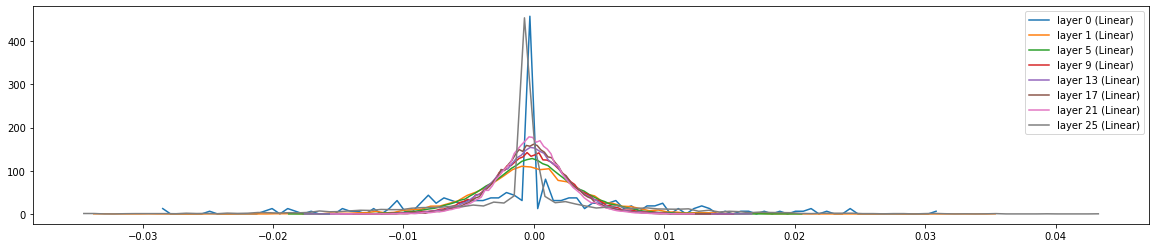

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(
            f'weight {str(tuple(p.shape)):<10}: '
            f'mean: {t.mean().item():+.4f}, std: {t.std().item():.4f}, '
            f'grad:data: {(p.grad / p.data).mean().item():+.4f}'
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({l.__class__.__name__})')
plt.legend(legends);

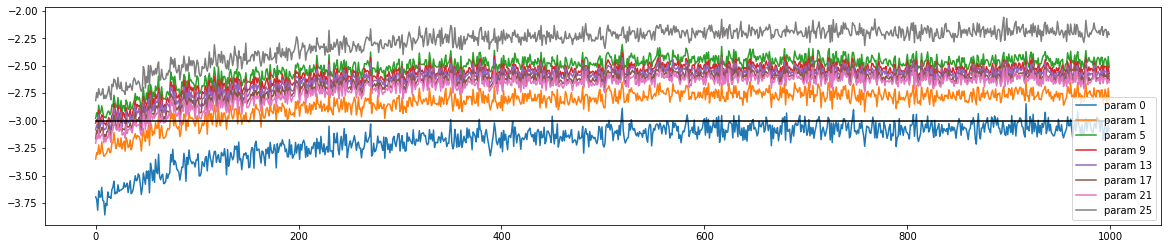

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = [ud_by_param[i] for ud_by_param in ud_by_param_by_iter.values()]
        plt.plot(t)
        legends.append(f'param {i}')
plt.plot([0, len(ud_by_param_by_iter)], [-3, -3], 'k')
plt.legend(legends);